In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent  # Assuming notebook is in experiments/notebooks/
sys.path.insert(0, str(project_root))
print(sys.path)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from experiments.analysis_utils.data_processing import read_directory
from experiments.analysis_utils.visualization import plot_reaction_speed_distribution, plot_token_distribution

['/home/rotsker/PycharmProjects/dg-research-revision', '/home/rotsker/miniconda3/envs/radCAD/lib/python312.zip', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/lib-dynload', '', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/site-packages']


# Reaction data

In [26]:
def read_reaction_data(path_to_runs: Path):
    from experiments.analysis_utils.data_processing import postprocess_proposal_data, postprocess_start_data, postprocess_timestep_data, set_run_id
    proposal_df_list, start_data_df_list, timestep_data_df_list = [], [], []
    for p_to_tables in path_to_runs.iterdir():
        proposals_p = p_to_tables.joinpath("proposals_data.parquet")
        start_data_p = p_to_tables.joinpath("common_data.parquet")
        timestep_data_p = p_to_tables.joinpath("timestep_data.parquet")
        if not proposals_p.exists() or not start_data_p.exists() or not timestep_data_p.exists():
            print(p_to_tables)
            continue
        proposals_df = pd.read_parquet(proposals_p)
        start_data_df = pd.read_parquet(start_data_p)
        timestep_data_df = pd.read_parquet(timestep_data_p)

        modeled_reactions = p_to_tables.name
        start_data_df['modeled_reactions'] = modeled_reactions

        proposal_df_list.append(proposals_df)
        start_data_df_list.append(start_data_df)
        timestep_data_df_list.append(timestep_data_df)
        
    proposal_df_full = pd.concat(proposal_df_list)
    start_data_df_full = pd.concat(start_data_df_list)
    timestep_data_df_full = pd.concat(timestep_data_df_list)

    postprocess_proposal_data(proposal_df_full)
    postprocess_start_data(start_data_df_full)
    postprocess_timestep_data(timestep_data_df_full)
    
    set_run_id(proposal_df_full, start_data_df_full, timestep_data_df_full)
    return proposal_df_full, start_data_df_full, timestep_data_df_full

# Read the data
path_to_runs = Path("../../results/simulations/withdrawal_queue_replacement_modeled_reactions_study/")
# path_to_runs = Path("../../results/simulations/model_validation/")
print(path_to_runs.resolve())
print(path_to_runs.resolve().exists())
proposal_df_full, start_data_df_full, timestep_data_df_full = read_reaction_data(path_to_runs)

/home/rotsker/PycharmProjects/dg-research-revision/results/simulations/withdrawal_queue_replacement_modeled_reactions_study
True


In [27]:
from experiments.analysis_utils.metrics import analyze_veto_timing_by_seals

veto_stats = analyze_veto_timing_by_seals(timestep_data_df_full, start_data_df_full, additional_columns=('modeled_reactions',))
print("Veto statistics by seal parameters:")
display(veto_stats)

Veto statistics by seal parameters:


veto_rate  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions              
0.01                         0.1                           Accelerated            100.0   
                                                           Normal                 100.0   
                                                           Slowed                  97.0   

                                                                              mean_time_to_veto  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions                      
0.01                         0.1                           Accelerated                22.410000   
                                                           Normal                     26.030000   
                                                           Slowed                     31.185567   

                                                                              median_time_to_veto  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions                        
0.01                         0.1                           Accelerated                       23.0   
                                                           Normal                            26.0   
                                                           Slowed                            31.0   

                                                                              hours_mean_time_to_veto_hours  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions                                  
0.01                         0.1                           Accelerated                            67.230000   
                                                           Normal                                 78.090000   
                                                           Slowed                                 93.556701   

                                                                              hours_median_time_to_veto_hours  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions                                    
0.01                         0.1                           Accelerated                                   69.0   
                                                           Normal                                        78.0   
                                                           Slowed                                        93.0   

                                                                              total_runs  
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions              
0.01                         0.1                           Accelerated               100  
                                                           Normal                    100  
                                                           Slowed                    100

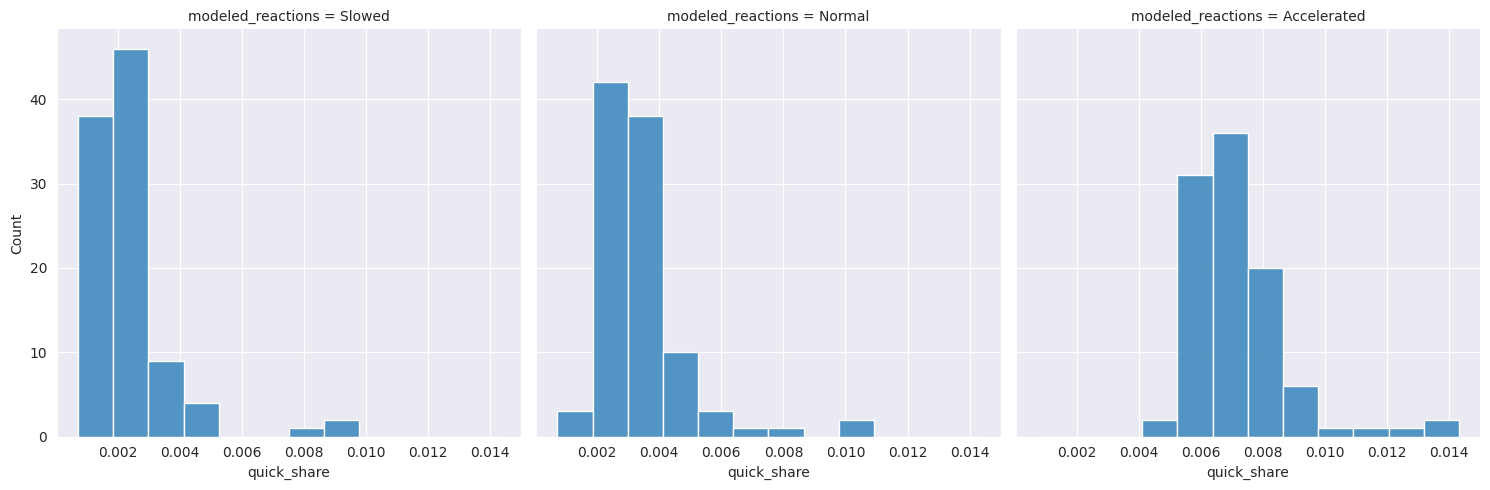

In [42]:
timestep_data_df_full_start = timestep_data_df_full[timestep_data_df_full['timestep'] == 1]
timestep_data_df_full_start = timestep_data_df_full_start.merge(start_data_df_full, on='run_id', how='left')
timestep_data_df_full_start['quick_share'] = timestep_data_df_full_start.balance_Quick / timestep_data_df_full_start.actors_total_balance
timestep_data_df_full_start['normal_share'] = timestep_data_df_full_start.balance_Normal / timestep_data_df_full_start.actors_total_balance
timestep_data_df_full_start['total_acting_share'] = timestep_data_df_full_start.quick_share + timestep_data_df_full_start.normal_share
sns.set_style('darkgrid')
sns.displot(timestep_data_df_full_start, x='quick_share', col='modeled_reactions', kind='hist')


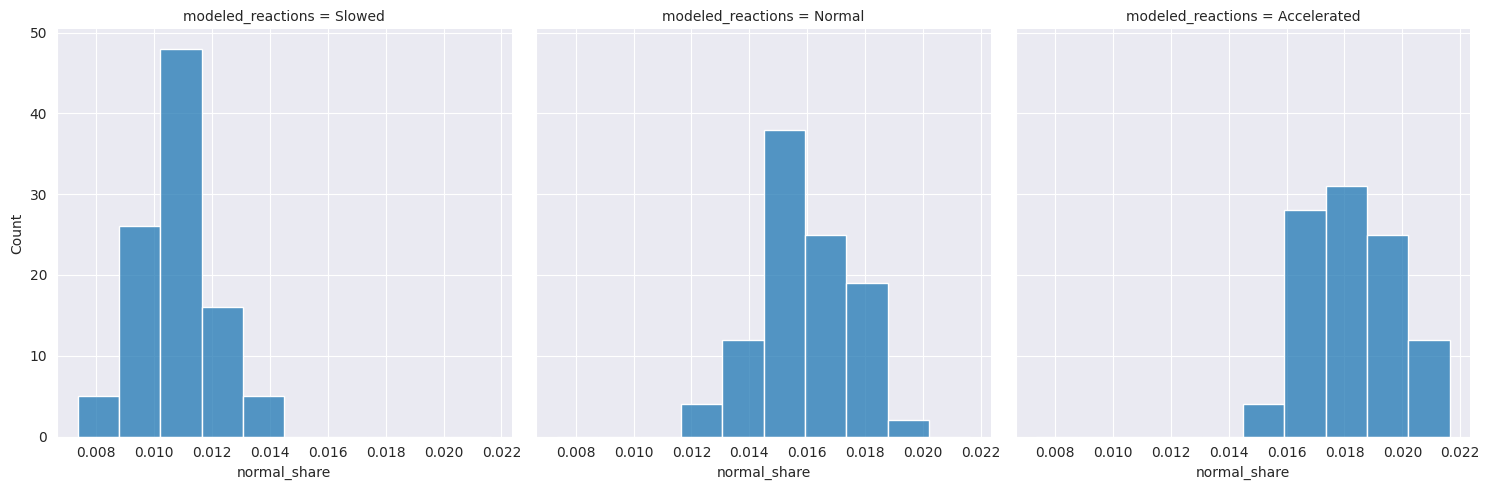

In [43]:
sns.displot(timestep_data_df_full_start, x='normal_share', col='modeled_reactions', kind='hist')


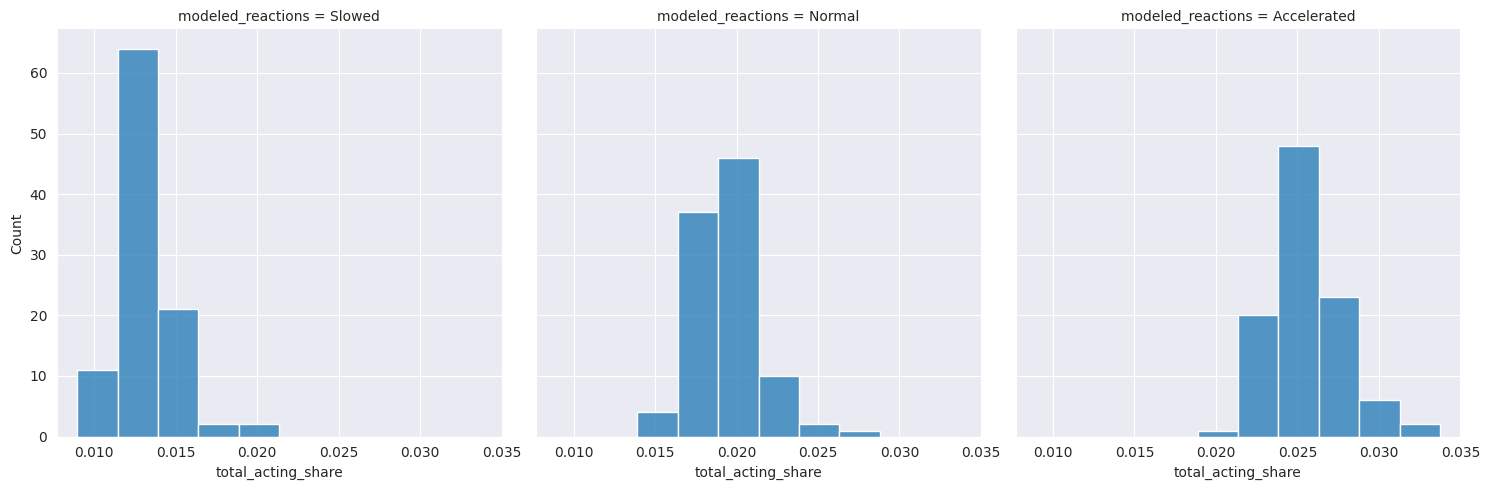

In [45]:
sns.displot(timestep_data_df_full_start, x='total_acting_share', col='modeled_reactions', kind='hist')


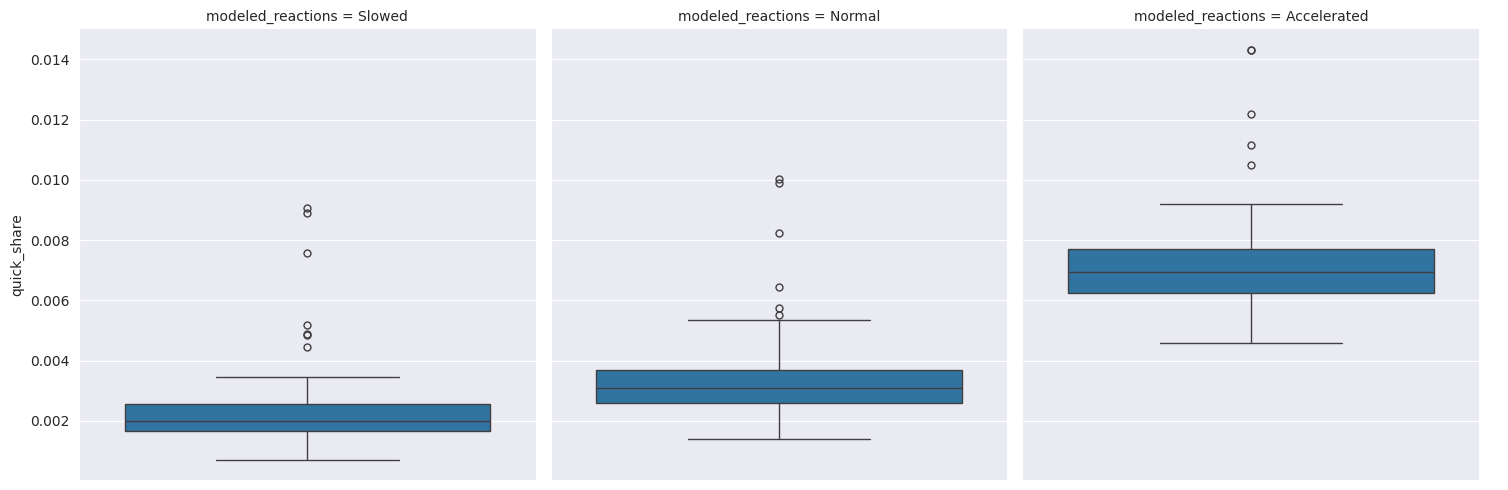

In [46]:
sns.catplot(timestep_data_df_full_start, y='quick_share', col='modeled_reactions', kind='box')

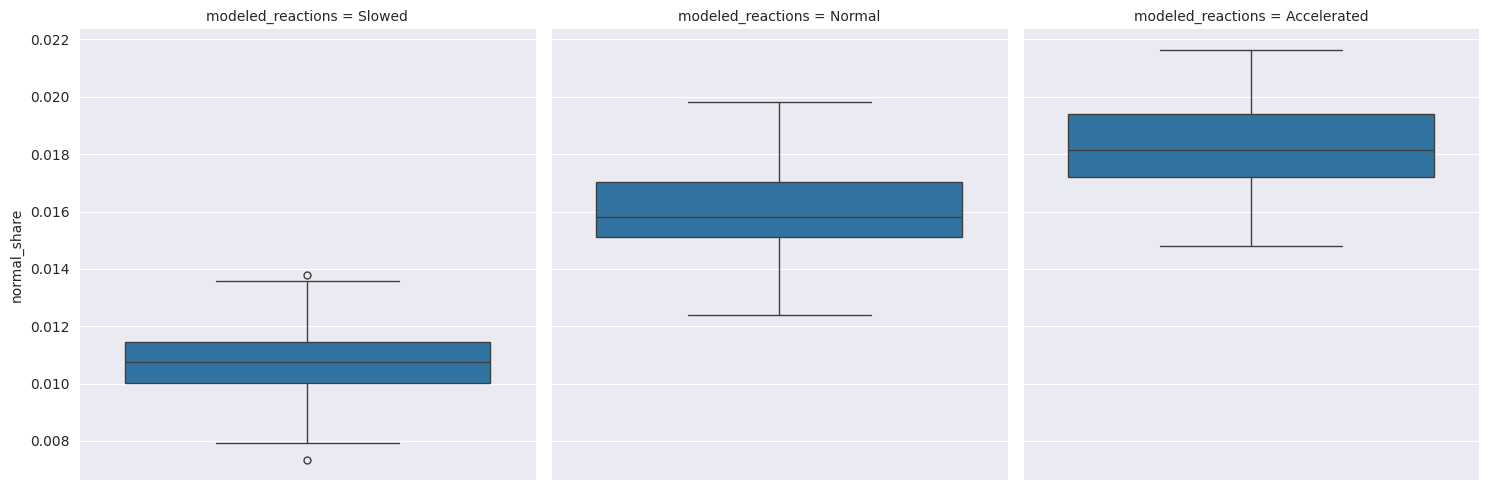

In [47]:
sns.catplot(timestep_data_df_full_start, y='normal_share', col='modeled_reactions', kind='box')

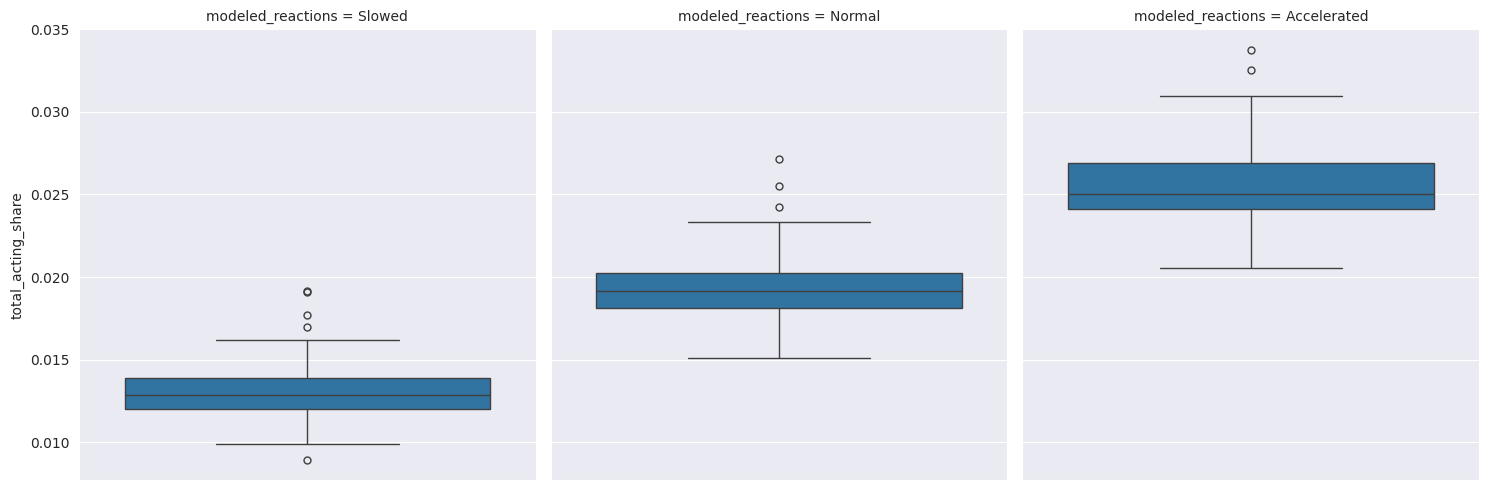

In [48]:
sns.catplot(timestep_data_df_full_start, y='total_acting_share', col='modeled_reactions', kind='box')

In [24]:
from experiments.analysis_utils.metrics import analyze_ragequit_timing_by_seals

ragequit_stats = analyze_ragequit_timing_by_seals(timestep_data_df_full, start_data_df_full, additional_columns=('modeled_reactions',))
print("Ragequit statistics by seal parameters:")
display(ragequit_stats)

Ragequit statistics by seal parameters:


ragequit_rate  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions                  
0.01                         0.1                           Accelerated                100.0   
                                                           Normal                     100.0   
                                                           Slowed                      97.0   

                                                                              mean_time_to_ragequit  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions                          
0.01                         0.1                           Accelerated                   382.410000   
                                                           Normal                        386.030000   
                                                           Slowed                        391.185567   

                                                                              median_time_to_ragequit  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions                            
0.01                         0.1                           Accelerated                          383.0   
                                                           Normal                               386.0   
                                                           Slowed                               391.0   

                                                                              hours_mean_time_to_ragequit_hours  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions                                      
0.01                         0.1                           Accelerated                              1147.230000   
                                                           Normal                                   1158.090000   
                                                           Slowed                                   1173.556701   

                                                                              hours_median_time_to_ragequit_hours  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions                                        
0.01                         0.1                           Accelerated                                     1149.0   
                                                           Normal                                          1158.0   
                                                           Slowed                                          1173.0   

                                                                              total_runs  
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions              
0.01                         0.1                           Accelerated               100  
                                                           Normal                    100  
                                                           Slowed                    100

# Veto Seal Data

In [2]:
# Read the data
path_to_runs = Path("../../results/simulations/withdrawal_queue_replacement_vetoseal_study/")
# path_to_runs = Path("../../results/simulations/model_validation/")
print(path_to_runs.resolve())
print(path_to_runs.resolve().exists())
vetoseal_proposal_df_full, vetoseal_start_data_df_full, vetoseal_timestep_data_df_full = read_directory(path_to_runs.resolve())

/home/rotsker/PycharmProjects/dg-research-revision/results/simulations/withdrawal_queue_replacement_vetoseal_study
True


In [22]:
from experiments.analysis_utils.metrics import analyze_veto_timing_by_seals

veto_stats = analyze_veto_timing_by_seals(vetoseal_timestep_data_df_full, vetoseal_start_data_df_full, additional_columns=tuple())
print("Veto statistics by seal parameters:")
display(veto_stats)

Veto statistics by seal parameters:


,,veto_rate,mean_time_to_veto,median_time_to_veto,hours_mean_time_to_veto_hours,hours_median_time_to_veto_hours,total_runs
first_seal_rage_quit_support,second_seal_rage_quit_support,,,,,,
0.0050,0.05,100.000000,21.528302,22.0,64.584906,66.0,106
0.0075,0.05,100.000000,24.028302,24.0,72.084906,72.0,106
0.0100,0.05,100.000000,26.028302,26.0,78.084906,78.0,106
0.0125,0.05,100.000000,28.226415,28.0,84.679245,84.0,106
0.0200,0.05,16.666667,37.437500,38.0,112.312500,114.0,96
0.0300,0.05,0.000000,NaN,NaN,NaN,NaN,96


# RageQuit data

In [18]:
# Read the data
path_to_runs = Path("../../results/simulations/withdrawal_queue_replacement_rageseal_study/")
# path_to_runs = Path("../../results/simulations/model_validation/")
print(path_to_runs.resolve())
print(path_to_runs.resolve().exists())
ragequit_proposal_df_full, ragequit_start_data_df_full, ragequit_timestep_data_df_full = read_directory(path_to_runs.resolve())

/home/rotsker/PycharmProjects/dg-research-revision/results/simulations/withdrawal_queue_replacement_rageseal_study
True


In [25]:
from experiments.analysis_utils.metrics import analyze_ragequit_timing_by_seals

ragequit_stats = analyze_ragequit_timing_by_seals(ragequit_timestep_data_df_full, ragequit_start_data_df_full, additional_columns=tuple())
print("Ragequit statistics by seal parameters:")
display(ragequit_stats)

Ragequit statistics by seal parameters:


ragequit_rate  \
first_seal_rage_quit_support second_seal_rage_quit_support                  
0.005                        0.050                                  100.0   
                             0.075                                  100.0   
                             0.100                                  100.0   
                             0.125                                  100.0   
                             0.150                                  100.0   

                                                            mean_time_to_ragequit  \
first_seal_rage_quit_support second_seal_rage_quit_support                          
0.005                        0.050                                         381.56   
                             0.075                                         381.56   
                             0.100                                         381.56   
                             0.125                                         381.56   
                             0.150                                         381.56   

                                                            median_time_to_ragequit  \
first_seal_rage_quit_support second_seal_rage_quit_support                            
0.005                        0.050                                            382.0   
                             0.075                                            382.0   
                             0.100                                            382.0   
                             0.125                                            382.0   
                             0.150                                            382.0   

                                                            hours_mean_time_to_ragequit_hours  \
first_seal_rage_quit_support second_seal_rage_quit_support                                      
0.005                        0.050                                                    1144.68   
                             0.075                                                    1144.68   
                             0.100                                                    1144.68   
                             0.125                                                    1144.68   
                             0.150                                                    1144.68   

                                                            hours_median_time_to_ragequit_hours  \
first_seal_rage_quit_support second_seal_rage_quit_support                                        
0.005                        0.050                                                       1146.0   
                             0.075                                                       1146.0   
                             0.100                                                       1146.0   
                             0.125                                                       1146.0   
                             0.150                                                       1146.0   

                                                            total_runs  
first_seal_rage_quit_support second_seal_rage_quit_support              
0.005                        0.050                                 100  
                             0.075                                 100  
                             0.100                                 100  
                             0.125                                 100  
                             0.150                                 100